In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib import colormaps
from matplotlib.animation import FuncAnimation 
import pickle
import sys, os
sys.path.insert(0, os.path.join("..", "source"))
import mass_spring_model
from simulation_util import SummaryFunctions

In [2]:
def get_ensemble(filepath, num_units=3, num_nodes=8, has_light_col=False):  # move all this stuff to source code
    ensemble_data = pickle.load(open(filepath,"rb"))
    headers = ["t"] + np.array([[f"phi {i}", f"mem. phi {i}", f"score {i}",
        f"mem. score {i}", f"learn cycle {i}", f"ds {i}", f"tcl {i}", f"A {i}"] 
        for i in range(num_units)]).flatten().tolist() + np.array([[f"x{i}", f"y{i}"]
        for i in range(num_nodes)]).flatten().tolist() 
    if has_light_col: 
        headers = ["t"] + np.array([[f"phi {i}", f"mem. phi {i}", f"score {i}",
            f"mem. score {i}", f"learn cycle {i}", f"ds {i}", f"tcl {i}", f"A {i}"] 
            for i in range(num_units)]).flatten().tolist() + ["light_x"] + np.array([[f"x{i}", f"y{i}"]
            for i in range(num_nodes)]).flatten().tolist() 
    return [pd.DataFrame(x, columns=headers) for x in ensemble_data]

def diff(lst, a=np.pi): # successive differences in R/[-a,a] ("else 0" is an approxiamtion)
    return [lst[i]-lst[i-1] if abs(lst[i]-lst[i-1])<a else 0 for i in range(1,len(lst))]

def v_x_angle(df, num_nodes=8, init_angle=5/4 * np.pi, with_light=False):
    sol_col = np.array([[f"x{i}", f"y{i}"] for i in range(num_nodes)]).flatten().tolist()
    df = df.assign(comx=df[sol_col[::2]].mean(axis=1),comy=df[sol_col[1::2]].mean(axis=1))
    df = df.assign(vx=[0] + [(df.comx[i]-df.comx[i-1])/(df.t[i]-df.t[i-1]) for i in range(1,len(df.comx))])
    shifted = np.array([x.to_numpy()-df[["comx","comy"]].to_numpy() for x in np.split(df[sol_col],num_nodes,axis=1)])
    df = df.assign(angle=np.rad2deg((init_angle - np.mean([np.unwrap([np.arctan2(*r)-np.arctan2(*v[0]) for r in v]) 
                                               for v in shifted],axis=0))%(2*np.pi)))
    if with_light: return df[["t","comx","comy","vx","angle","light_x"]]
    return df[["t","comx","comy","vx","angle"]]

def to_avg_bins(df, measurement_times):
    df = df.assign(tidx=np.digitize(df["t"], measurement_times)).groupby("tidx").mean()
    empty = pd.DataFrame(columns=df.columns,index=np.arange(1,len(measurement_times)))
    return pd.concat([df, empty[empty.index.isin(df.index) == False]]).sort_index()

def avg_v_x_angle(ensemble, measurement_times):
    return pd.DataFrame(np.array([to_avg_bins(x, measurement_times).to_numpy() for x in ensemble]).mean(axis=0),
                         columns=["t","comx","comy","vx","angle"])

def heatmap(file_subset, extract_func,vary_cols,avg,symm=False,cdct={0.0: 0, 0.01: 1, 0.04: 2, 0.16: 3}):
    grd = zip(file_subset[vary_cols].to_numpy(), file_subset.index)
    hm = np.zeros((4,4))
    for xy, i in grd:
        hm[cdct[xy[1]],cdct[xy[0]]] = extract_func(avg[i])
    if symm:  # artificial symmetrisation because separately generated files sometimes don't exactly match (but are generally close together)
        hm = (hm.T + hm)/2
    return hm

def hm_plot(hm,xlabel,ylabel,title,ax,cdct):
    im = ax.imshow(hm)
    ax.set_xticks(np.arange(hm.shape[0]), labels=cdct.keys())
    ax.set_yticks(np.arange(hm.shape[1]), labels=cdct.keys())
    for i in range(hm.shape[0]):
        for j in range(hm.shape[1]):
            text = ax.text(j, i, f"{str(hm[i,j]):.5}", ha="center", va="center")
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel); ax.set_title(title);

In [3]:
files = []; path = os.path.join("..", "data", "sweeps", "30_10_2022", "triangle_amp")
for file in os.listdir(path):
    if file.endswith(".p"): files.append(file)
file_info = pd.DataFrame(list(map(lambda x: [float(x[0][0]),float(x[0][1]),float(x[0][2][:-2]),float(x[0][3][:-5]),x[1]], 
    [(f.split("_")[2:],f) for f in files])),columns=["amp1","amp2","amp3","ang","filename"])
len(file_info)

60

In [4]:
dataframes = []
for i in range(len(file_info)):
    dataframes.append([v_x_angle(x,init_angle=np.deg2rad(file_info.loc[i][3])) 
                       for x in get_ensemble(os.path.join(path,file_info.loc[i][4]))])

In [5]:
avg_data = [avg_v_x_angle(df_lst,np.linspace(0,3000,11)) for df_lst in dataframes]

[None, None, None, None]

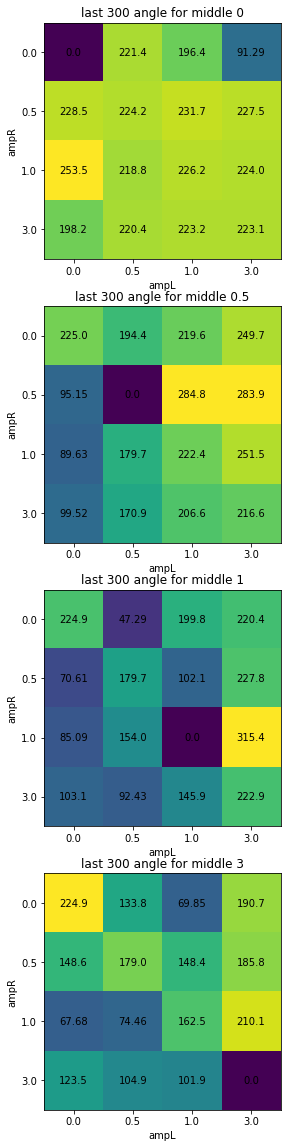

In [6]:
fig, ax = plt.subplots(4,1,figsize=(5,20)); dct = {0.0:0, 0.5:1, 1.0:2, 3.0:3}
[hm_plot(heatmap(file_info[file_info.amp3==x],lambda x:x.angle.tolist()[-1],["amp1","amp2"],avg_data,
         cdct=dct),"ampL","ampR",f"last 300 angle for middle {x}",ax[i],dct) for i,x in enumerate([0,0.5,1,3])]

In [101]:
def avg_max_extension(amplitudes):
    ext = {0.0: 0.0, 0.5: 0.0016970562748477164, 1.0: 0.003422396820942891, 3.0: 0.01040861181906598}
    return np.mean([ext[a] for a in amplitudes])

KeyError: 1.0

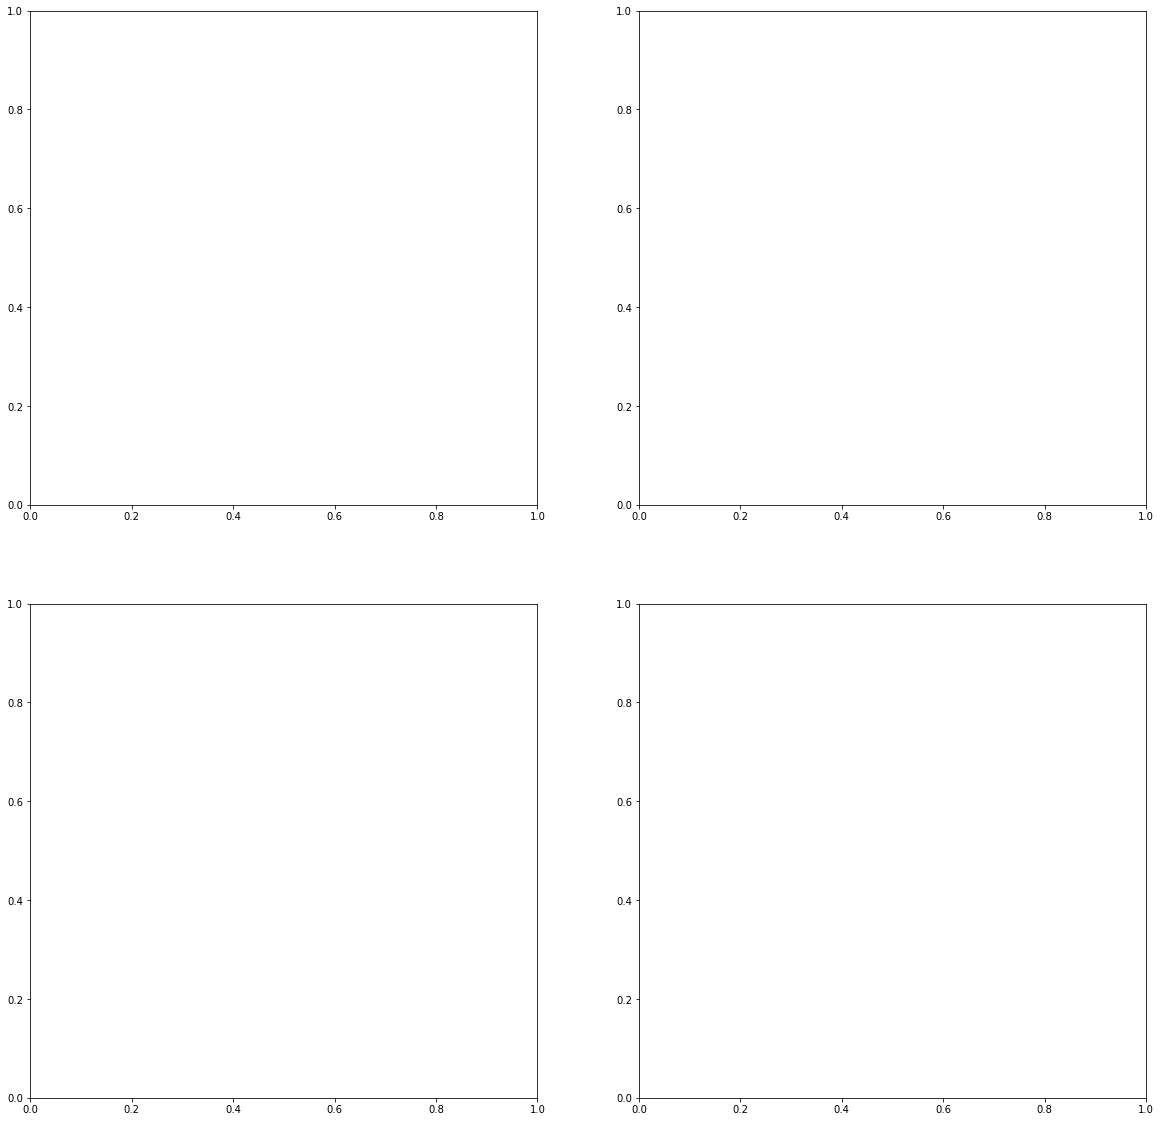

In [106]:
ig, ax = plt.subplots(2,2,figsize=(20,20)); dct = {0.0:0, 0.5:1, 1.0:2, 3.0:3}
[heatmap(file_info[file_info.amp3==j],lambda x: x,["amp1","amp2"],avg_data) for j in [0,0.5,1,3]]

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize
def colour_path_plt(df,ax,no_light=False):
    cmap = colormaps["hsv"]; idx = np.linspace(0,1,360)[df.angle.astype(int)]
    scat = ax.scatter(df.comx,df.comy,s=0.01,c=cmap(idx))
    if not no_light:
        switch = np.where(np.concatenate([df.light_x.to_numpy()[1:] != df.light_x.to_numpy()[:-1], [False]]))[0]
        ax.scatter(df.comx[switch], df.comy[switch],s=100,c='black',marker="*")
    ax.scatter(df.comx[0], df.comy[0],s=100,c='black',marker=">")
    divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05)
    ColorbarBase(cax,cmap=cmap,norm=Normalize(vmin=0,vmax=360),ticks=np.arange(19)*20).set_label("angle [deg]")

In [9]:
def animation(position_data, num_nodes=8, elements=[(0, 1), (0, 2), (2, 3), (1, 3), (0, 3), (1, 2), (4, 5), (4, 1), (1, 6), (5, 6), (4, 6), (5, 1), (3, 7), (6, 7), (1, 7), (6, 3)],
              framerate=10, size=((-0.2,1.2),(-0.5,1))):
    fig = plt.figure(); #TODO: add time please
    ax = plt.axes(xlim=size[0], ylim=size[1]) 
    ax.set_aspect(1)
    lines = [plt.plot([], [], lw=2, marker='o', c="g", zorder=3)[0] for _ in range(len(elements))]
    plt.grid(True, linestyle='-.')
    def animate(i): 
        U = position_data[i*framerate,-num_nodes*2:]
        for i, el in enumerate(elements): 
            lines[i].set_data([U[2*el[0]], U[2*el[1]]], [U[2*el[0]+1], U[2*el[1]+1]])
    ani = FuncAnimation(fig,animate,frames=len(position_data)//framerate)
    from IPython.display import HTML
    return HTML(ani.to_jshtml())

In [10]:
ens = [x for x in get_ensemble(os.path.join(path,file_info[
    (file_info.amp1==3.0) & (file_info.amp2==0.0) & (file_info.amp3==1.0)]["filename"].tolist()[0]))]
ens_processed = [v_x_angle(x) for x in ens]

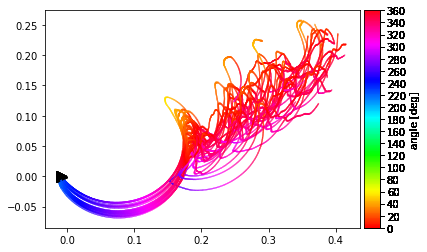

In [11]:
fig, ax = plt.subplots(1,1)
[colour_path_plt(y,ax,no_light=True) for y in ens_processed[:]]
plt.show()

In [39]:
ens = [x for x in get_ensemble(os.path.join(path,file_info[
    (file_info.amp1==0.0) & (file_info.amp2==3.0) & (file_info.amp3==1.0)]["filename"].tolist()[0]))]
ens_processed = [v_x_angle(x) for x in ens]

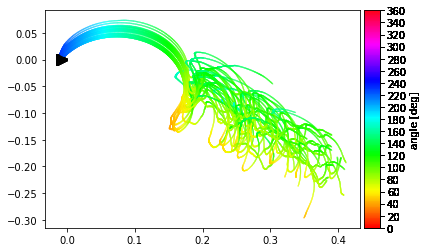

In [40]:
fig, ax = plt.subplots(1,1)
[colour_path_plt(y,ax,no_light=True) for y in ens_processed[:]]
plt.show()

Text(0, 0.5, 'angle [deg]')

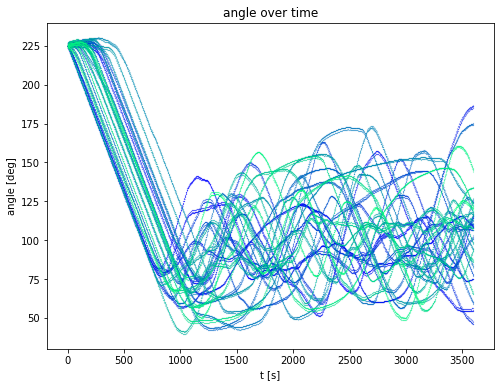

In [41]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
cmap = colormaps["winter"]; idx = np.linspace(0,1,len(ens_processed)); 
[ax.scatter(np.arange(len(x["angle"])),x["angle"],s=0.01,color=cmap(idx[i])) for i,x in enumerate(ens_processed)]
ax.set_title("angle over time"); ax.set_xlabel("t [s]"); ax.set_ylabel("angle [deg]")

(-0.003, 0.003)

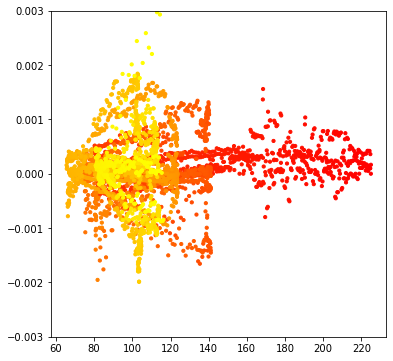

In [99]:
fig, ax = plt.subplots(figsize=(6,6))
[ax.scatter(ens_processed[i]["angle"],ens_processed[i]["vx"],s=10,c=cmap(np.linspace(0,1,len(ens_processed[i])))) for i in range(len(ens_processed[:1]))]
ax.set_ylim(-0.003,0.003)

In [38]:
ens_processed = [v_x_angle(x) for x in get_ensemble(os.path.join(path,file_info[
    (file_info.amp1==1.0) & (file_info.amp2==3.0) & (file_info.amp3==1.0)]["filename"].tolist()[0]))]

In [72]:
def info_plots(ax, ensemble):
    [colour_path_plt(y,ax[0],no_light=True) for y in ensemble[:]]
    cmap = colormaps["winter"]; idx = np.linspace(0,1,len(ensemble)); 
    [ax[1].scatter(np.arange(len(x["angle"])),x["angle"],s=0.01,color=cmap(idx[i])) for i,x in enumerate(ensemble)]
    ax[1].set_title("angle over time"); ax[1].set_xlabel("t [s]");
    cmap = colormaps["autumn"]; 
    [ax[2].scatter(ensemble[i]["angle"],ensemble[i]["vx"],s=0.1,c=cmap(np.linspace(0,1,len(ensemble[i])))) for i in range(len(ensemble[:]))]
    ax[2].set_ylim(-0.003,0.003); ax[2].set_title("vx over angle")

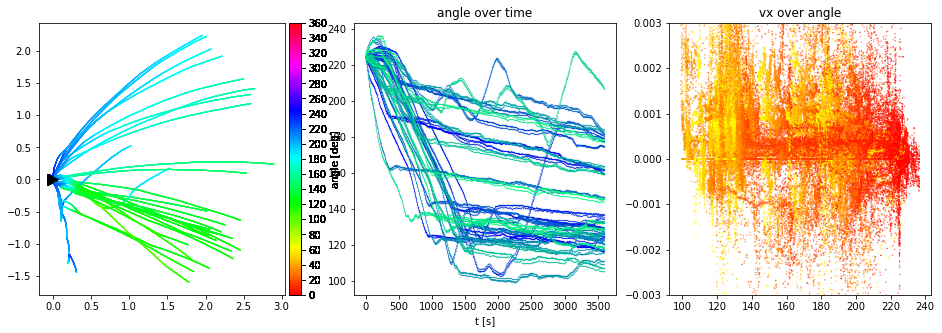

In [75]:
fig, ax = plt.subplots(1,3,figsize=(16,5))
info_plots(ax,[v_x_angle(sim) for sim in get_ensemble(os.path.join(path,file_info[
    (file_info.amp1==1.0) & (file_info.amp2==3.0) & (file_info.amp3==1.0)]["filename"].tolist()[0]))])

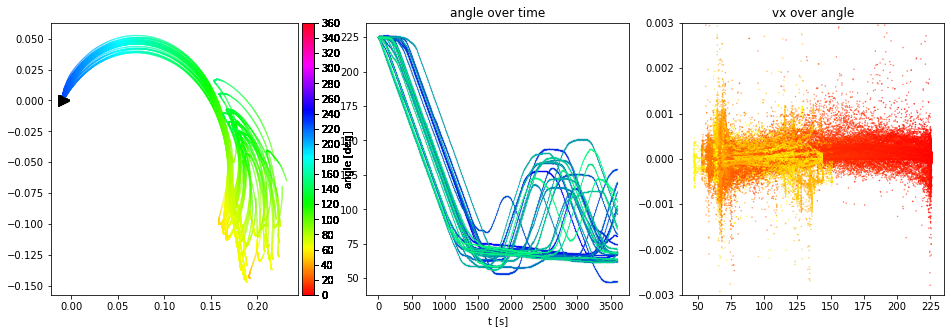

In [79]:
fig, ax = plt.subplots(1,3,figsize=(16,5))
info_plots(ax,[v_x_angle(sim) for sim in get_ensemble(os.path.join(path,file_info[
    (file_info.amp1==0) & (file_info.amp2==1.0) & (file_info.amp3==1.0)]["filename"].tolist()[0]))])

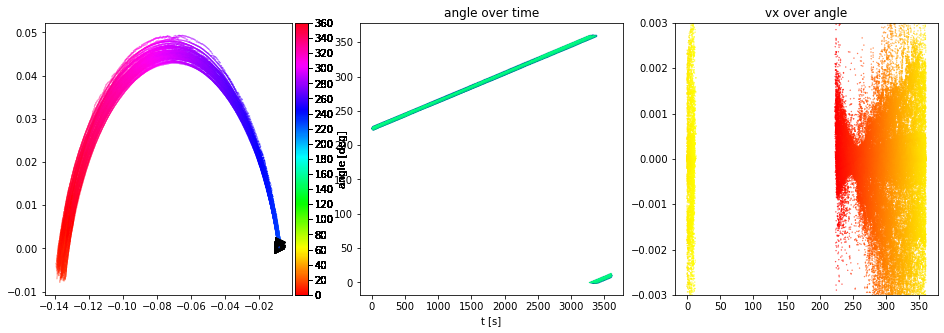

In [83]:
fig, ax = plt.subplots(1,3,figsize=(16,5))
info_plots(ax,[v_x_angle(sim) for sim in get_ensemble(os.path.join(path,file_info[
    (file_info.amp1==0) & (file_info.amp2==3) & (file_info.amp3==0)]["filename"].tolist()[0]))])

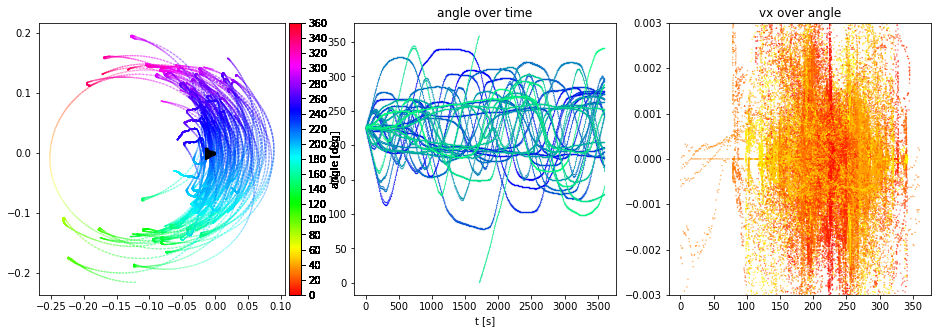

In [92]:
fig, ax = plt.subplots(1,3,figsize=(16,5))
info_plots(ax,[v_x_angle(sim) for sim in get_ensemble(os.path.join(path,file_info[
    (file_info.amp1==3) & (file_info.amp2==3) & (file_info.amp3==0)]["filename"].tolist()[0]))])

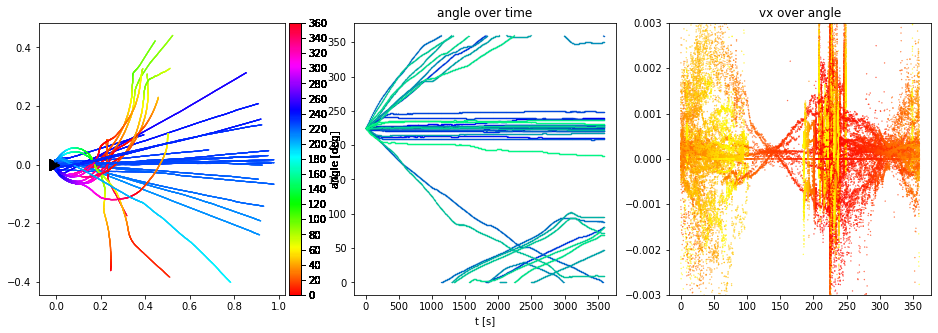

In [100]:
fig, ax = plt.subplots(1,3,figsize=(16,5))
info_plots(ax,[v_x_angle(sim) for sim in get_ensemble(os.path.join(path,file_info[
    (file_info.amp1==0.5) & (file_info.amp2==0.5) & (file_info.amp3==3)]["filename"].tolist()[0]))])

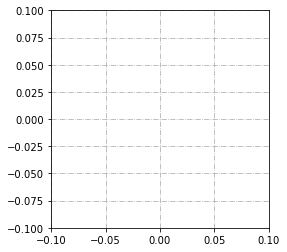

In [108]:
animation(ens[1].to_numpy()[:,-16:],size=((-0.1,0.1),(-0.1,0.1)))